In [1]:
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
import pickle
import scipy.interpolate
import scipy.misc
class UltrasoundData:
    def __init__(self, filename):
        with open(filename, "rb") as file:
            p = pickle.load(file)
            #print(p[0])
            self.rawImages = p[0]
            
            self.rot, self.trans, self.otime = p[1]
            self.otime = np.array(self.otime, dtype=np.float)
            self.otime /= 1000
        
        
        self.rotAngles = np.arctan2(self.rot[:, 2, 0], self.rot[:, 2, 2])
        
        
        self.getRotAngle = scipy.interpolate.interp1d(self.otime, self.rotAngles, assume_sorted=True)

   
    def makeData(self):
        self.monoImages = np.sum(self.rawImages[1], 3).astype(np.float)
        
        
        self.angles = self.getRotAngle(self.rawImages[0])
        self.angles = np.concatenate([self.angles, -self.angles])

        self.data = np.array([scipy.misc.imresize(arr, (100, 100)) for arr in self.monoImages]).reshape(-1, 100, 100, 1) / 255
        del self.monoImages
        self.data = np.concatenate([self.data, np.flip(self.data, 2)])
        
        #self.data = np.concatenate([self.data[6:], self.data[3:-3], self.data[:-6]], 2)
        self.classes = self.angles.copy() #np.array([self.angles, np.zeros(self.angles.shape)]).transpose()
        """
        self.classes /= 2
        
        self.classes += .5
        self.classes *= 15
        
        self.classes = keras.utils.to_categorical(self.classes.astype(np.int), 30)
        
        del self.rawImages
        """

udata = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack.pickle")
udata.makeData()

udata2 = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack2.pickle")
udata2.makeData()

In [3]:
udata3 = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack3.pickle")
udata3.makeData()
traindata = np.concatenate([udata3.data, udata2.data, udata.data[:50000]])
testdata = udata.data[50000:].copy()

trainclasses = np.concatenate([udata3.classes, udata2.classes, udata.classes[:50000]])
testclasses = udata.classes[50000:].copy()


In [3]:
from keras.models import Sequential
model = Sequential()

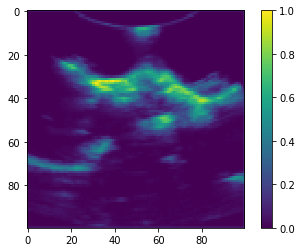

In [5]:
import matplotlib.pyplot as plt
plt.imshow(udata.data[5730, :, :, 0])
plt.colorbar()
plt.show()

#model.predict(udata.data[51730:51731]), udata.classes[51730]

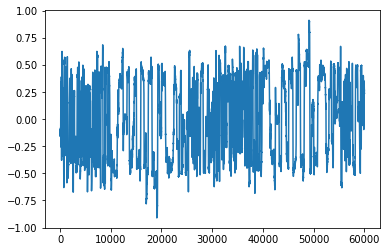

In [6]:
plt.plot(udata.classes)
plt.show()

In [1]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers

Using TensorFlow backend.


In [4]:
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(100, 100, 1)
                 
                ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.6))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.6))
model.add(Dense(1, activation='tanh'))

"""
import keras.backend as K
#def logLikelyhoodLoss(x_pred, x_true):
#    return (.1 * -K.mean(-(x_pred[:, 0] - x_true[:, 0])**2 / ( (1 + x_pred[:, 1] )) - K.log(np.pi *(1 + x_pred[:, 1])), -1)
#            + K.mean(K.abs(x_pred[:, 0] - x_true[:, 0]), -1))

def logLikelyhoodLoss(x_pred, x_true):
    return -K.mean(-K.sqrt((x_pred[:, 0] - x_true[:, 0])**2), -1)"""

'\nimport keras.backend as K\n#def logLikelyhoodLoss(x_pred, x_true):\n#    return (.1 * -K.mean(-(x_pred[:, 0] - x_true[:, 0])**2 / ( (1 + x_pred[:, 1] )) - K.log(np.pi *(1 + x_pred[:, 1])), -1)\n#            + K.mean(K.abs(x_pred[:, 0] - x_true[:, 0]), -1))\n\ndef logLikelyhoodLoss(x_pred, x_true):\n    return -K.mean(-K.sqrt((x_pred[:, 0] - x_true[:, 0])**2), -1)'

In [8]:
model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.adam(lr=.00002))

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [22]:

#del udata.data, udata2.data, udata3.data
model.fit(traindata, 
          trainclasses,
          batch_size=200,
          epochs=30,
          verbose=1,
          validation_data=(testdata, testclasses))

Train on 170000 samples, validate on 10000 samples
Epoch 1/30
170000/170000 [==============================] - 82s - loss: 0.0276 - val_loss: 0.0483
Epoch 2/30
170000/170000 [==============================] - 67s - loss: 0.0275 - val_loss: 0.0486
Epoch 3/30
170000/170000 [==============================] - 68s - loss: 0.0275 - val_loss: 0.0487
Epoch 4/30
170000/170000 [==============================] - 66s - loss: 0.0275 - val_loss: 0.0484
Epoch 5/30
170000/170000 [==============================] - 67s - loss: 0.0275 - val_loss: 0.0485
Epoch 6/30
170000/170000 [==============================] - 67s - loss: 0.0274 - val_loss: 0.0484
Epoch 7/30
170000/170000 [==============================] - 67s - loss: 0.0274 - val_loss: 0.0484
Epoch 8/30
170000/170000 [==============================] - 67s - loss: 0.0273 - val_loss: 0.0486
Epoch 9/30
170000/170000 [==============================] - 66s - loss: 0.0274 - val_loss: 0.0486
Epoch 10/30
170000/170000 [==============================] - 66s - 

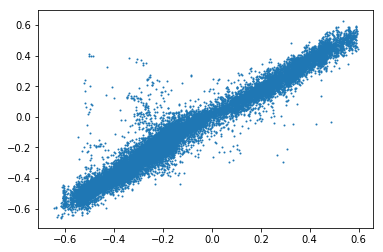

In [66]:
plt.scatter(trainclasses[:20000].flatten() , model.predict(traindata[:20000]).flatten(), 1)
#plt.plot([-1, 1], [-1, 1])
plt.show()

In [19]:
model.predict(udata.data[57000:])

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

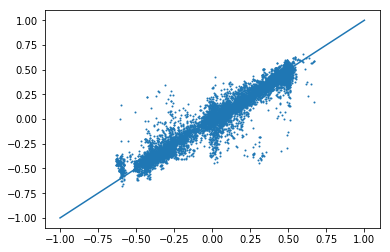

In [15]:
import matplotlib.pyplot as plt
plt.scatter(udata.classes[50000:].flatten() , model.predict(udata.data[50000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

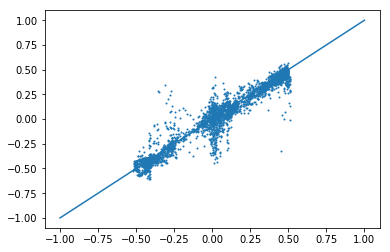

In [14]:
plt.scatter(udata.classes[57000:].flatten() , model.predict(udata.data[57000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

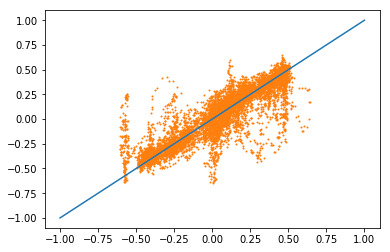

In [20]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

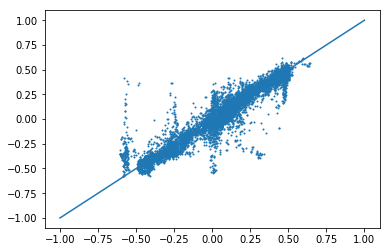

In [11]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

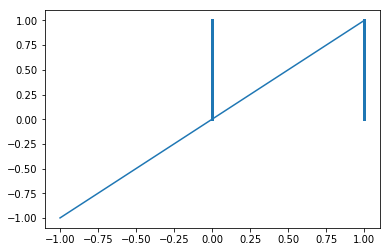

In [30]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

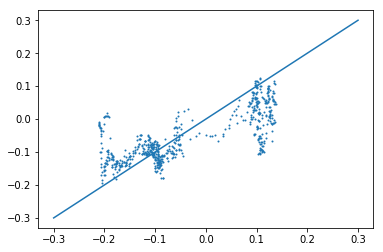

In [28]:
plt.scatter(udata.classes[6000:6600].flatten() , model.predict(udata.data[6000:6600]).flatten(), 1)
plt.plot([-.3, .3], [-.3, .3])
plt.show()

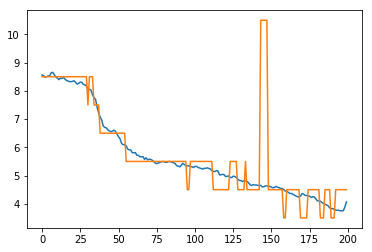

In [29]:
offset = 59000
length = 200

plt.plot(udata.angles[offset:offset + length])

plt.plot(np.argmax(model.predict(udata.data[offset:offset + length]), 1) + .5)
plt.show()

In [1]:

length = 1000
offset = 3000
plt.plot(testclasses[offset:offset + length])
plt.plot(model.predict(testdata[offset:offset + length]).flatten())
plt.show()

NameError: name 'plt' is not defined

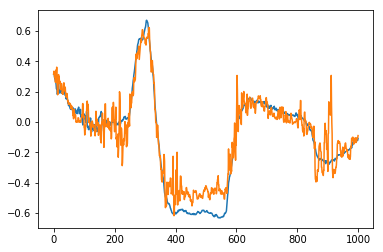

In [19]:

length = 1000
offset = 5000
plt.plot(testclasses[offset:offset + length])
plt.plot(model.predict(testdata[offset:offset + length]).flatten())
plt.show()

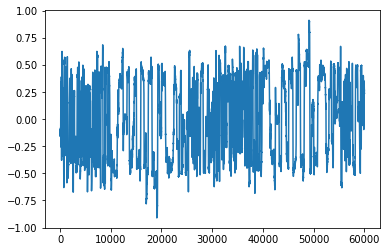

In [11]:
plt.plot(udata.classes)
plt.show()

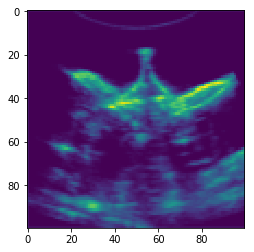

In [40]:
plt.imshow(udata3.data[59600, :, :, 0])
plt.show()

In [106]:
td.shape

(100, 100, 100, 1)

In [107]:
tc.shape

(100, 2)

In [14]:
import h5py

In [18]:
h5py.run_tests()

.....................................................x...............................s...................................x....................................s........ss.ss...........................................................................ss...................ssssss.................................................................x....x........................x.....x......................................ssssssssss...............
----------------------------------------------------------------------
Ran 439 tests in 1.105s

OK (skipped=24, expected failures=6)


<unittest.runner.TextTestResult run=439 errors=0 failures=0>

In [136]:
f = model.layers[0]

In [137]:
w = f.weights[0]

In [138]:
a, b = f.get_weights()

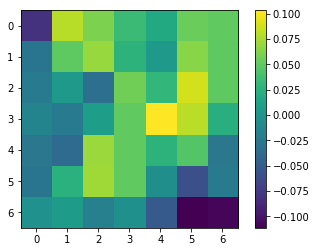

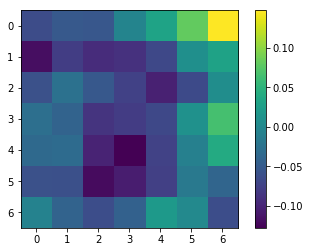

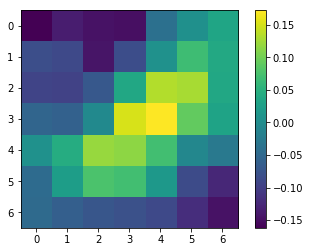

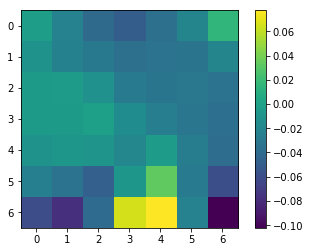

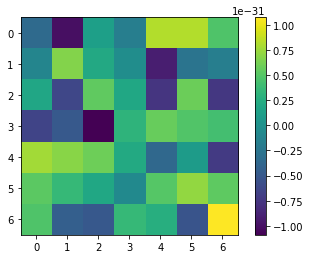

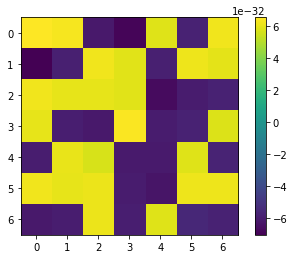

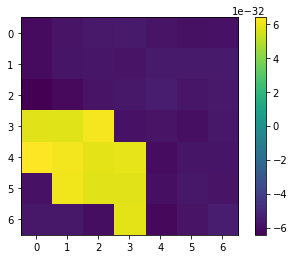

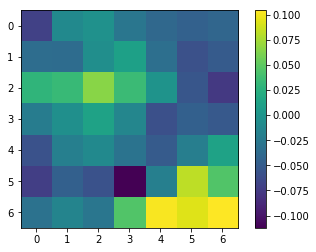

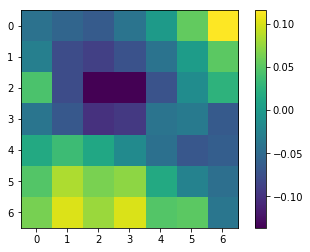

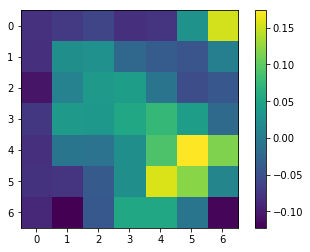

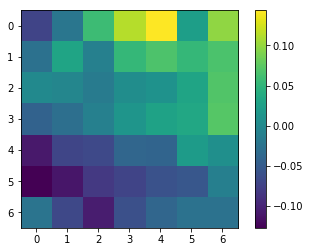

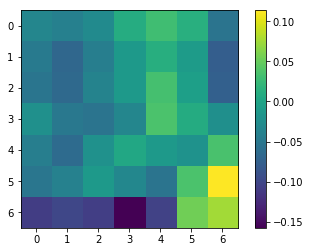

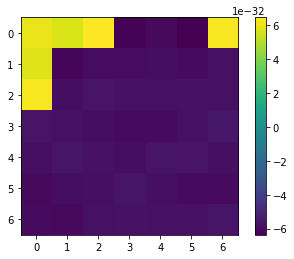

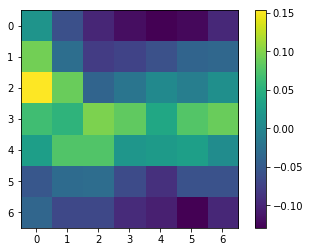

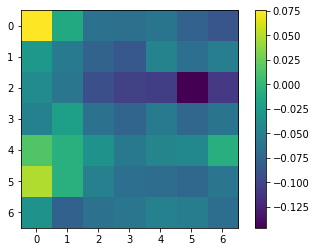

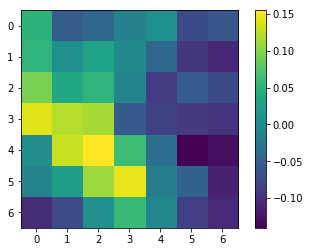

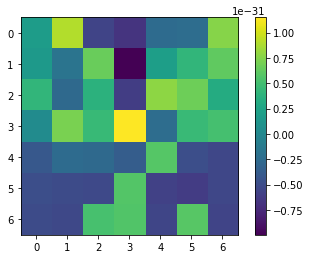

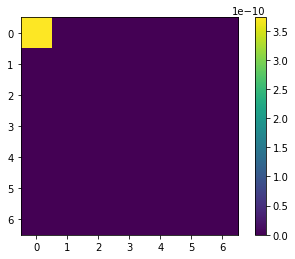

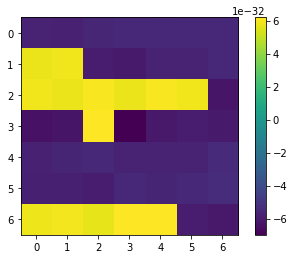

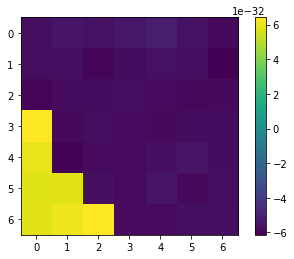

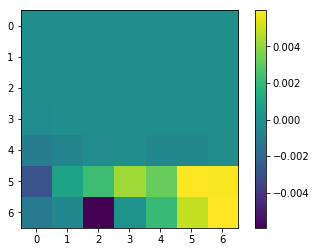

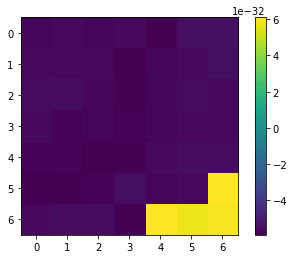

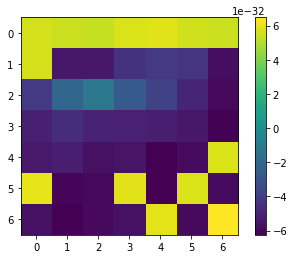

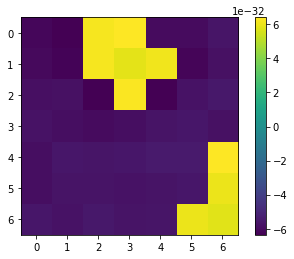

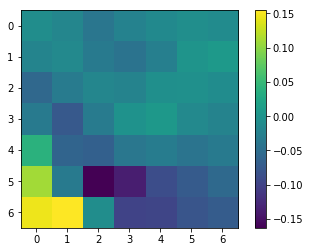

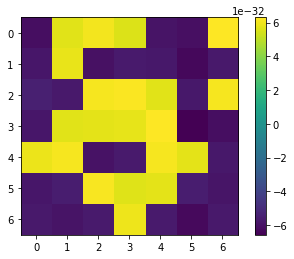

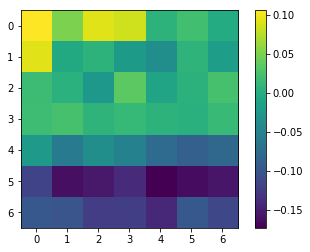

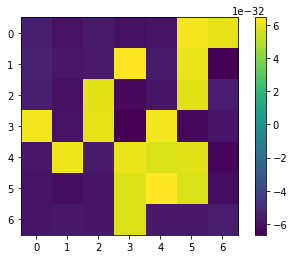

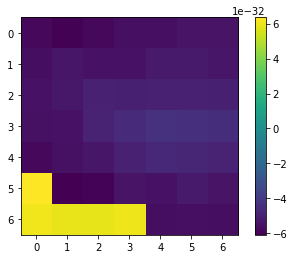

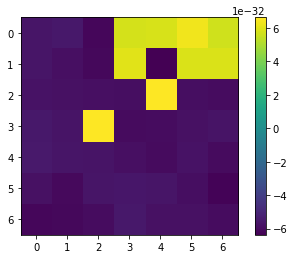

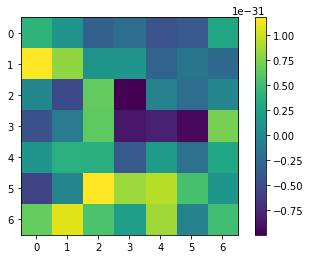

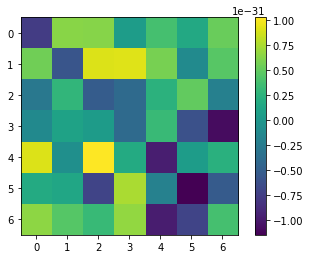

In [139]:
for i in range(32):
    
    plt.imshow(a[:,:,0,i])
    plt.colorbar()
    plt.show()

In [19]:
np.min(udata.classes)

-0.91066218265574239

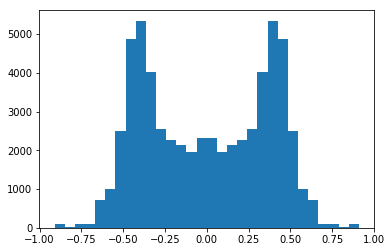

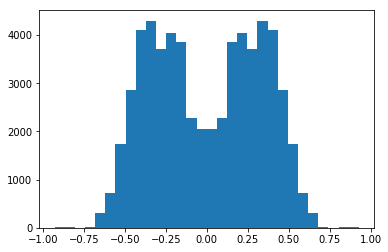

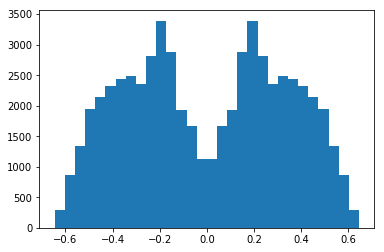

In [28]:
plt.hist(udata.classes, 30)
plt.show()
plt.hist(udata2.classes, 30)
plt.show()
plt.hist(udata3.classes, 30)
plt.show()

In [20]:
model.pop()
model.pop()
model.pop()



In [37]:

testdataProcessed = model.predict(testdata)
traindataProcessed = model.predict(traindata)

In [21]:
model.predict(testdata[0:1])

array([[-0.03142308]], dtype=float32)

In [30]:
for layer in model.layers:
    print(layer.name)


conv2d_6
max_pooling2d_4
conv2d_7
max_pooling2d_5
conv2d_8
max_pooling2d_6
conv2d_9
conv2d_10
flatten_2
dense_4
dropout_3
dense_5
dropout_4


In [27]:
model.pop?

In [ ]:
from keras.models import Model

layer_name = 'dense_4'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

In [40]:
pickle.dump( testdataProcessed, open("testdataprocessed2.pickle", "wb"))

In [41]:
pickle.dump( traindataProcessed, open("traindataprocessed2.pickle", "wb"))

In [42]:
traindataProcessed.shape

(170000, 512)

In [43]:
model.save("dataProcessor")

In [7]:
with open("testclasses.pickle", "wb") as file:
    pickle.dump(testclasses, file)
    
with open("trainclasses.pickle", "wb") as file:
    pickle.dump(trainclasses, file)